In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt

In [ ]:
# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# A series of image transformations for training data augmentation:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.RandomErasing(p=0.25)
])

# Create separate transform for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Load CIFAR-10 dataset
train_set = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, K=4, r=16, dropout_rate=0.1):
        super().__init__()
        self.K = K

        # Expert branch as specified in requirements
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // r)
        self.fc2 = nn.Linear(in_channels // r, K)

        # Create K separate convolutional expert branches
        self.convs = nn.ModuleList()
        for _ in range(K):
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout_rate)
            ))

        # Flag to enable/disable residual connection
        self.use_residual = True

    def forward(self, x):
        identity = x

        # Expert branch processing
        x_pooled = self.avgpool(x)
        x_pooled = x_pooled.view(x_pooled.size(0), -1)

        # Compute attention weights
        a = F.relu(self.fc1(x_pooled))
        a = self.fc2(a)

        # Softmax to get normalized attention weights
        a = F.softmax(a, dim=1)

        # Process input through all K expert branches
        conv_outputs = [conv(x) for conv in self.convs]

        # Compute weighted sum of expert outputs
        out = torch.zeros_like(x)
        for i, conv_out in enumerate(conv_outputs):
            out = out + conv_out * a[:, i].view(-1, 1, 1, 1)

        # Add residual connection if enabled
        if self.use_residual:
            out = out + identity

        return out

class Classifier(nn.Module):
    def __init__(self, N=4, K=5, r=16, C=96, dropout_rate=0.2):
        super().__init__()

        # Stem: Simple convolutional layer to extract features
        self.stem = nn.Sequential(
            nn.Conv2d(3, C, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(C),
            nn.ReLU(inplace=True)
        )

        # Backbone: N blocks with intermediate downsampling
        self.blocks = nn.ModuleList()

        # First stage (N blocks at original resolution)
        for _ in range(N):
            self.blocks.append(Block(C, K, r, dropout_rate=dropout_rate))

        # Transition layer (downsampling and channel increase)
        self.transition = nn.Sequential(
            nn.BatchNorm2d(C),
            nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(C*2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )

        # Second stage (N blocks at reduced resolution)
        for _ in range(N):
            self.blocks.append(Block(C*2, K, r, dropout_rate=dropout_rate))

        # Classifier head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(C*2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # Stem
        x = self.stem(x)

        # First stage blocks
        for i in range(len(self.blocks) // 2):
            x = self.blocks[i](x)

        # Transition layer
        x = self.transition(x)

        # Second stage blocks
        for i in range(len(self.blocks) // 2, len(self.blocks)):
            x = self.blocks[i](x)

        # Classifier head
        return self.classifier(x)


In [ ]:
# Training tracking variables
train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_of_epochs = 50

# Initialize model
model = Classifier(N=4, K=5, r=16, C=96, dropout_rate=0.2).to(device)

# Initialize optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-2)

# Loss function with label smoothing to prevent overconfidence
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Gradient scaler for mixed-precision training
scaler = torch.amp.GradScaler()

# Calculate total training steps for scheduler
total_steps = len(train_loader) * num_of_epochs

# One-cycle learning rate scheduler configuration
scheduler = OneCycleLR(optimizer, max_lr=2e-3, total_steps=total_steps, pct_start=0.1, div_factor=25, final_div_factor=1000)

Epoch 01
Train Loss: 1.9749 | Acc: 29.18%
Val Loss: 1.7556 | Acc: 39.77%
Epoch 02
Train Loss: 1.7362 | Acc: 41.83%
Val Loss: 1.5320 | Acc: 51.37%
Epoch 03
Train Loss: 1.6052 | Acc: 48.82%
Val Loss: 1.5172 | Acc: 53.33%
Epoch 04
Train Loss: 1.5287 | Acc: 52.98%
Val Loss: 1.3504 | Acc: 60.94%
Epoch 05
Train Loss: 1.4640 | Acc: 56.02%
Val Loss: 1.4086 | Acc: 59.13%
Epoch 06
Train Loss: 1.3956 | Acc: 59.83%
Val Loss: 1.2432 | Acc: 67.24%
Epoch 07
Train Loss: 1.3383 | Acc: 62.31%
Val Loss: 1.2420 | Acc: 67.37%
Epoch 08
Train Loss: 1.2937 | Acc: 64.66%
Val Loss: 1.1695 | Acc: 70.61%
Epoch 09
Train Loss: 1.2548 | Acc: 66.76%
Val Loss: 1.1557 | Acc: 70.78%
Epoch 10
Train Loss: 1.2174 | Acc: 68.40%
Val Loss: 1.1190 | Acc: 72.85%
Epoch 11
Train Loss: 1.1824 | Acc: 70.08%
Val Loss: 1.0383 | Acc: 76.76%
Epoch 12
Train Loss: 1.1522 | Acc: 71.57%
Val Loss: 1.0480 | Acc: 75.88%
Epoch 13
Train Loss: 1.1186 | Acc: 73.13%
Val Loss: 1.0274 | Acc: 77.16%
Epoch 14
Train Loss: 1.0861 | Acc: 74.65%
Val Loss:

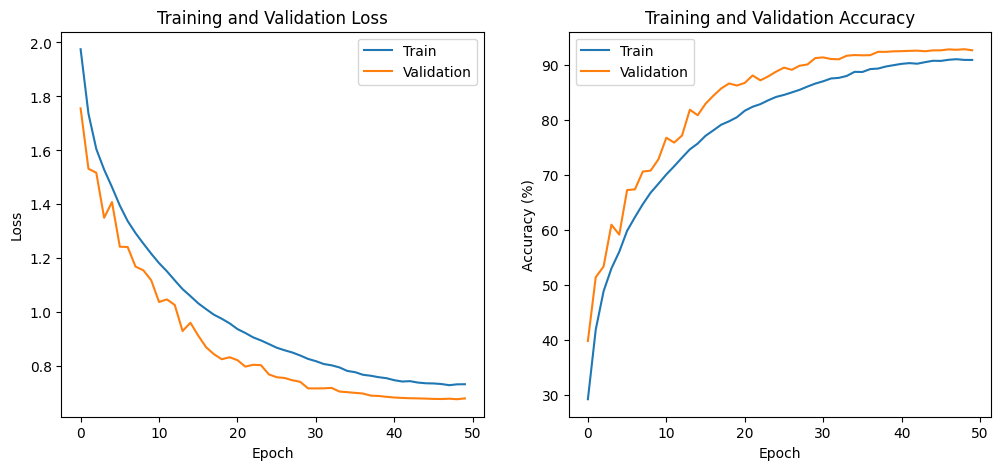

Latest validation accuracy: 92.68%


In [ ]:
# Training loop
for epoch in range(num_of_epochs):
    # ========== Training Phase ==========
    model.train()
    epoch_train_loss, correct, total = 0, 0, 0

    # Iterate through training batches
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Mixed precision training for efficiency
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backpropagation with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Track metrics
        epoch_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


    # ========== Validation Phase ==========
    model.eval()
    epoch_val_loss, val_correct, val_total = 0, 0, 0

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()


    # ========== Metrics Calculation ==========
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(test_loader)
    train_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # ========== Progress Reporting ==========
    print(f"Epoch {epoch+1:02d}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")


# Plot training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

print(f"Latest validation accuracy: {val_accs[-1]:.2f}%")